# Plan for analysis

Note: for ACL, what is mostly relevant is point 3. Focusing on that for the moment.

0. Stability of most frequent name:
 - attempt 1 (check rounds 0, 1, 2, 3) **DONE** -- not really informative

1. Name adequacy:
 - distribution of adequacy of all names (all data, not per image). **DONE**
 - proportion of names/image that are adequate (boxplot?). Needs adequacy threshold (see variable adequacy_threshold)). 
 
2. Region ambiguity:
 - distribution of number of clusters per image (how many images have 1, 2, ... n clusters). Barplot (ordinal variable). 
 - distribution of response frequency per cluster (percentage of responses in cluster 0, 1, ... m). Boxplots? Or barplot with standard deviation bars?
 - distribution of total name frequency for canonical object (proportion of responses that go to the most frequent object, that is, cluster 0). (Expectation: mostly very high). 
 - analyze which cases are errors, which are bounding box ambiguity. 

==> estimate the n of images for which we have enough naming data (something like at least x adequate names for cluster 0?). 

3. For canonical object (cluster 0):
 - distribution of raw number of adequate names (needs threshold to determining whether name is adequate; see variable adequacy_threshold).  **DONE** 
     ==> Problem: not all canonical objects have same number of adequate names. Make number of adequate names relative? (TODO)
 - distribution of the frequency of the entry-level name in the canonical object.  **DONE**
 - how often the entry-level name coincides with the VG name (see if it's very different from the number we obtained before verification phase). **DONE**
 
4. (Do something with remaining clusters with adequate names, and other types of analyses)

In [121]:
# global variables
adequacy_threshold=0.5

In [148]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from collections import Counter

pd.set_option('display.max_colwidth', 180)
pd.set_option('expand_frame_repr', False)

In [179]:
#csvfile='../proc_data_phase0/verification/all_responses_round0-3_verified.csv'
#csvfile='kk.csv'
#csvfile = '../proc_data_phase0/verification/all_responses_round0-3_verified_entry-level-focus.csv'
df = pd.read_csv(csvfile, 
    converters={'responses_r0': eval, 'responses_r1': eval, 'responses_r2': eval, 'responses_r3': eval},
    sep="\t")

total_objects=len(df_all)
print("Total objects: ", total_objects)
df.columns

Total objects:  25315


Index(['vg_img_id', 'cat', 'synset', 'vg_obj_name', 'responses_r0', 'opt-outs',
       'vg_domain', 'top_response_domain_r0', 'responses_domains_r0', 'url',
       'sample_type', 'responses_domains_r1', 'responses_r1',
       'top_response_domain_r1', 'responses_domains_r2', 'responses_r2',
       'top_response_domain_r2', 'responses_domains_r3', 'responses_r3',
       'top_response_domain_r3', 'vg_object_id', 'all_responses', 'clean',
       'canon', 'spellchecked', 'spellchecked_min2', 'verified'],
      dtype='object')

# Stability of most frequent names
## Attempt 1:
We already see that around 20% of objects change most frequent names from round to round, but I'm not sure if it's super compelling.
One surprising result is that names in r3 still change a lot: I'd expect that it would go down for later rounds. Assuming I haven't made a mistake, one possible explanation: workers became aware that (since this is a generation task) we were not rejecting a lot of answers, and put less attention? If so, there should be more noise in r3 than in r2 (can be tested with verification data).

In [180]:
r=['responses_r0','responses_r1','responses_r2','responses_r3']
t=['top_name_r0','top_name_r1','top_name_r2','top_name_r3']
for rcolumn, tcolumn in zip(r,t):
    df[tcolumn]=df[rcolumn].apply(lambda x: max(x, key=x.get))

oldcol='top_name_r0'
for col in t[1:]:
    different=df[df[oldcol] != df[col]]
    out='names that change in {} wrt {}: {:.1%}'.format(col, oldcol, len(different)/total_objects)
    print(out)
    oldcol=col

names that change in top_name_r1 wrt top_name_r0: 20.6%
names that change in top_name_r2 wrt top_name_r1: 16.6%
names that change in top_name_r3 wrt top_name_r2: 19.4%


## Attempt 2:
I'll do it now by sampling 1, 2, ... elements from the pool of annotations, and computing the avg of objects that have the most frequent name, that is, the entry-level name (as estimated from the whole sample). (TODO)

In [182]:
# get necessary data from csv file
adequacies=[] # number of adequate names (total)
tot_names=0; tot_ad=0 # total n of names; n of -adequate names (see threshold above)
list_n_ad_names=[] # number of adequate names per canonical object
list_entry_names=[] # entry names for each canonical object (cluster 0)
list_freqs_entry_name=[] # entry names for each canonical object (cluster 0)
no_entry_lev=0
for row in df.itertuples():
    name_freqs=eval(row.spellchecked_min2)
    #print(name_freqs)
    # find entry-level name; this should be done for the canonical object,
    # but I can't recover the info from the verified column (name data in a dictionary),
    # so I use the one from all data and check if the entry level name form those data is in cluster 0
    # there are only 700 imgs where the most frequent name is not in cluster 0; TODO: check these cases; mend this
    entry_name,entry_freq=name_freqs.most_common(1)[0] # returns tuple, e.g. ('man',11) # problem: what if there's a tie of most common names? (happens, but rarely)
    d = literal_eval(row.verified) # dictionary with verification data
    n_ad_names_img=0
    freqs_canon_names=1 # *** SMOOTHING FOR THE CASE WHERE THERE ARE 0 CANONICAL NAMES; TO MEND IN FUTURE ***
    entry_name_in_cluster0=False
    for name in d.keys(): # each name for this object
        #print("\t",name)
        tot_names+=1
        values_dict = d[name]
        ad=values_dict['adequacy']
        adequacies.append(ad); 
        if ad > adequacy_threshold:
            tot_ad += 1
            if values_dict['cluster_id']==0: # labels canonical object
                n_ad_names_img += 1 # number of adequate names for that image
                freqs_canon_names += name_freqs[name] # total frequency of canonical names
                if name==entry_name: entry_name_in_cluster0=True

#    print("\t",freqs_canon_names)
    if entry_name_in_cluster0==False: entry_name,entry_freq=None,0 ### TO BE MENDED IN THE FUTURE (see comment 'find entry-level name' above)
    list_n_ad_names.append(n_ad_names_img)
    list_entry_names.append(entry_name)
    freq_entry_name=(entry_freq+1)/freqs_canon_names # *** SMOOTHING -- TO MEND ***
    list_freqs_entry_name.append(freq_entry_name)

df['n_canonical_names']=list_n_ad_names
df['entry_name']=list_entry_names
df['entry_freq']=list_freqs_entry_name

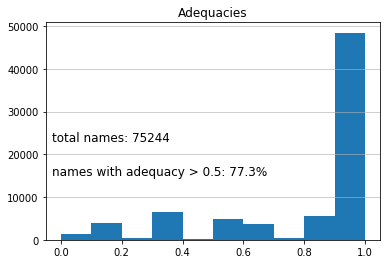

In [183]:
# Histogram for name adequacies
adequacies=np.array(adequacies)
plt.hist(x=adequacies)
plt.grid(axis='y', alpha=0.75)
plt.title('Adequacies')
to_write='total names: {}'.format(tot_names)
plt.text(-0.03,23000,to_write,fontsize='large')
to_write='names with adequacy > {}: {:.1%}'.format(adequacy_threshold, tot_ad/tot_names)
plt.text(-0.03,15000,to_write,fontsize='large')
plt.show()
plt.close()

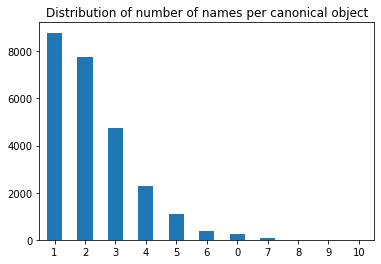

Index(['vg_img_id', 'cat', 'synset', 'vg_obj_name', 'responses_r0', 'opt-outs',
       'vg_domain', 'top_response_domain_r0', 'responses_domains_r0', 'url',
       'sample_type', 'responses_domains_r1', 'responses_r1',
       'top_response_domain_r1', 'responses_domains_r2', 'responses_r2',
       'top_response_domain_r2', 'responses_domains_r3', 'responses_r3',
       'top_response_domain_r3', 'vg_object_id', 'all_responses', 'clean',
       'canon', 'spellchecked', 'spellchecked_min2', 'verified', 'top_name_r0',
       'top_name_r1', 'top_name_r2', 'top_name_r3', 'n_canonical_names',
       'entry_name', 'entry_freq'],
      dtype='object')

In [184]:
ndist = df.n_canonical_names.value_counts()
ndist.plot(kind='bar',rot=0,title="Distribution of number of names per canonical object")
plt.show()
plt.close()
df.columns

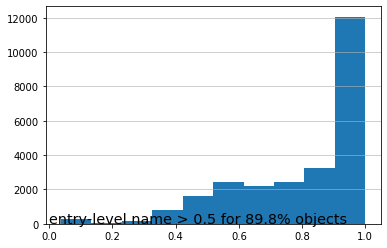

In [185]:
# Distribution of proportion (entry level name / all names), for canonical object
#weights = (np.ones_like(df.entry_freq)/float(total_objects))*100
#plt.hist(df.entry_freq, weights=weights)
plt.hist(df.entry_freq)
plt.grid(axis='y', alpha=0.75)
plt.set_ylabel="Percentage of all images"
t=len(df[df.entry_freq > 0.5])
to_write='entry-level name > 0.5 for {:.1%} objects'.format(t/total_objects)
plt.text(0,25,to_write,fontsize='x-large')
plt.show()
plt.close()

In [186]:
mismatch=len(df[df.entry_name == df.vg_obj_name])
print('Objects for which manynames entry level name coincides with VG name: {} ({:.1%})'.format(mismatch, mismatch/total_objects))
# slightly lower; could be due to the 700 cases that were assigned 'None' above?

Objects for which manynames entry level name coincides with VG name: 18278 (72.2%)


In [187]:
# Statistics wrt entry-level of object class != entry-level of its instances
# (i.e., entry- levels cannot be derived on class-level)

names_counts=df.entry_name.value_counts()
print(len(names_counts))
print(names_counts[:20])
print(names_counts[50:70])
print(names_counts[100:120])
print(names_counts[300:320])


420
woman         1420
man           1362
train         1130
shirt          995
giraffe        916
bed            881
airplane       881
horse          824
table          768
cat            759
bench          694
desk           682
dog            674
pizza          630
jacket         580
motorcycle     567
truck          524
boy            523
couch          491
boat           470
Name: entry_name, dtype: int64
floor              79
skater             74
bread              74
bathtub            74
van                69
knife              68
salad              61
tie                58
surfer             56
bottle             50
fork               48
sink               48
tent               45
cup                43
snowboarder        42
person             38
blender            36
catcher            36
flower             36
baseball player    32
Name: entry_name, dtype: int64
sweater          12
duck             11
sofa             11
mug              11
robe             11
sauce         

In [188]:
# number of objects per image (in a different cell cause the code above was getting too messy)
list_n_clusterximg=[] # number of clusters for each image
for row in df.itertuples():
    d = literal_eval(row.verified)
    s=set()
    for name in d.keys(): # each name for this object
        values_dict = d[name]
        s.add(values_dict['cluster_id'])
    nclus=len(s)
    list_n_clusterximg.append(nclus)

df['n_clusters']=list_n_clusterximg


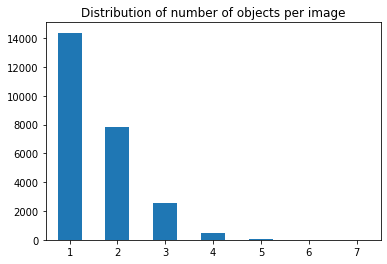

43.2% of images have more than one cluster


In [189]:
# import matplotlib.ticker as mtick
cldist = df.n_clusters.value_counts()
cldist.plot(kind='bar',rot=0,title="Distribution of number of objects per image")
# tried to show percentages in y axis, and failed... :/
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()
plt.close()

t=len(df[df.n_clusters > 1])
to_write='{:.1%} of images have more than one cluster'.format(t/total_objects)
#plt.text(to_write,xy=(.5,.7),xycoords='figure fraction',fontsize='x-large') # gives me trouble
print(to_write)